# Lab: XAI and Uncertainty for Time-Series Forecasting (Panama Load)

You are data scientists at a grid operator in Panama. Your task is short-term load forecasting, interpreting model behaviour (XAI), and estimating predictive uncertainty so operators can make safer operational decisions. This notebook walks you through EDA, feature engineering, training a model, SHAP explanations, temporal attribution with occlusion, bootstrap-based variability, and conformal prediction intervals.

Follow the TODO markers in code cells. The dataset is expected at `data/panama_load.csv` and should contain at least a timestamp column and a load column. Optional covariates (temperature, humidity, etc.) are welcome.

In [1]:
# Section 0 - Setup
# Imports, plotting style, and random seed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import shap
import warnings
warnings.filterwarnings('ignore')

# Plot style and seed
sns.set_style('whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/home/nacho/code/EEIA/p3-timeseries-IgnacioBayon/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 1 — Load data and basic EDA

Goal: understand the time series, inspect seasonality, and spot anomalies. Follow instructions and fill TODOs.

You can learn more about the dataset at: https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting

In [2]:
# 1) Load data into a DataFrame
path = '../data/panama_load.csv'
if not os.path.exists(path):
    print(f'WARNING: {path} not found. Please place the dataset at this path.')
df = pd.read_csv(path)
print(f'Data loaded with shape: {df.shape}')

Data loaded with shape: (48048, 17)


In [3]:
datetime_col = 'datetime' 
load_col = 'nat_demand'  
# Attempt to parse a datetime column robustly
if datetime_col not in df.columns:
    # try to guess a datetime-like column
    for c in df.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            datetime_col = c
            break
print('Using datetime column:', datetime_col)
# Parse datetimes
try:
    df[datetime_col] = pd.to_datetime(df[datetime_col])
except Exception as e:
    print('Error parsing datetimes:', e)
# Set index and sort
df = df.set_index(datetime_col).sort_index()

print('Using load column:', load_col)
# Keep a clean dataframe with at least datetime index and load
data = df[[load_col]].copy()
data.columns = ['load']
data = data.sort_index()
data.head()

Using datetime column: datetime
Using load column: nat_demand


,load
datetime,
2015-01-03 01:00:00,970.3450
2015-01-03 02:00:00,912.1755
2015-01-03 03:00:00,900.2688
2015-01-03 04:00:00,889.9538
2015-01-03 05:00:00,893.6865


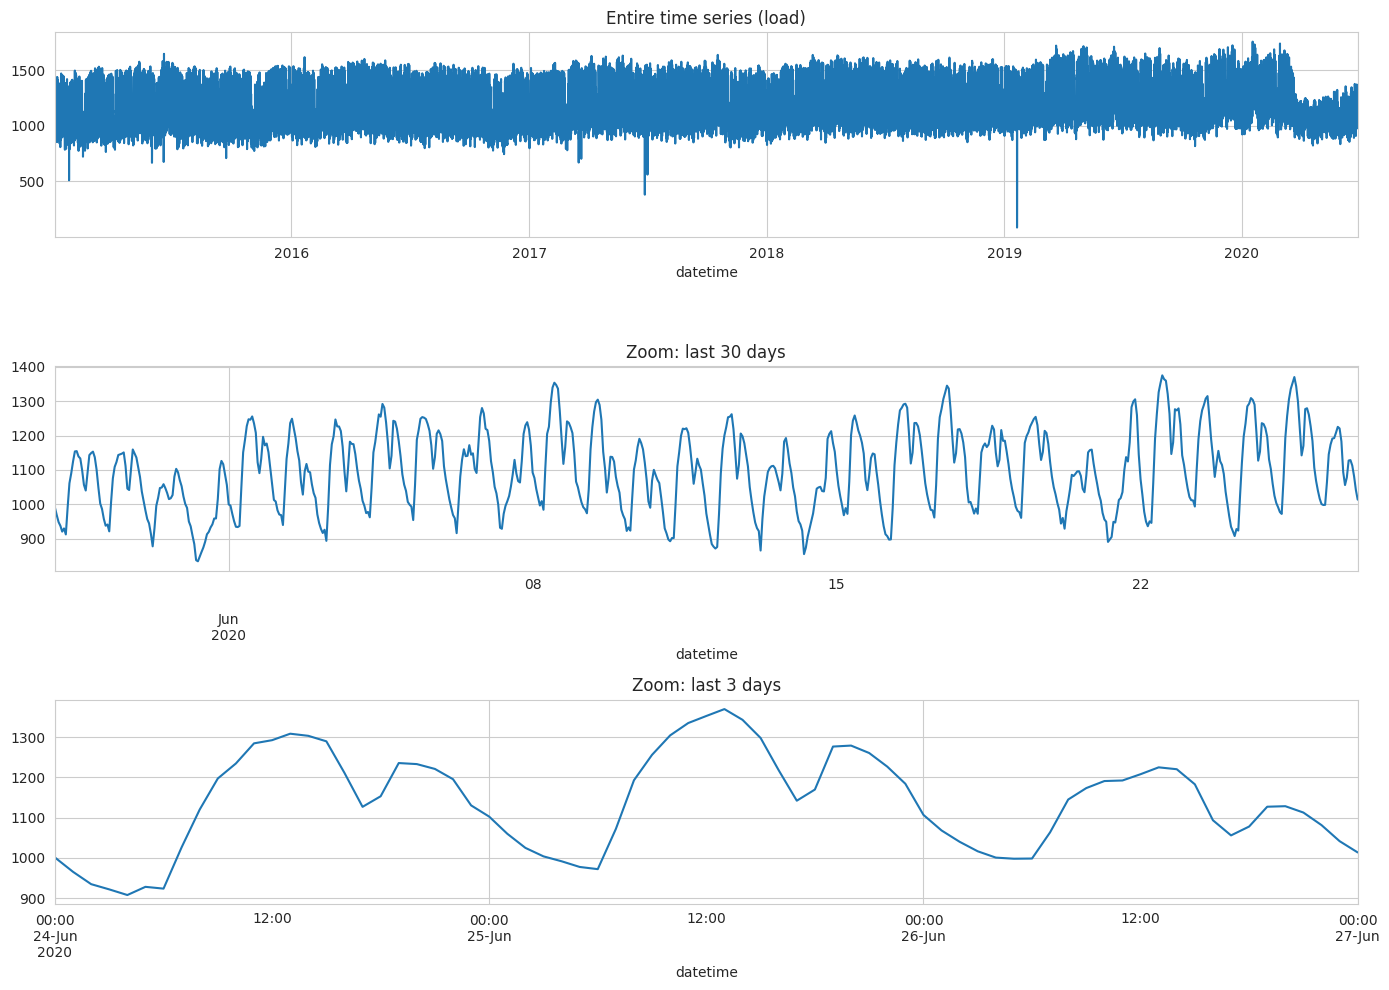

In [4]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Entire series
data['load'].plot(ax=ax[0], title='Entire time series (load)')
# Zoom into one month (choose the last available month)
last = data.index.max()
month_start = (last - pd.Timedelta(days=30)).ceil('D')
data.loc[month_start:last, 'load'].plot(ax=ax[1], title='Zoom: last 30 days')
# Zoom into a couple of days
days_start = (last - pd.Timedelta(days=3)).ceil('D')
data.loc[days_start:last, 'load'].plot(ax=ax[2], title='Zoom: last 3 days')
plt.tight_layout()
plt.show()

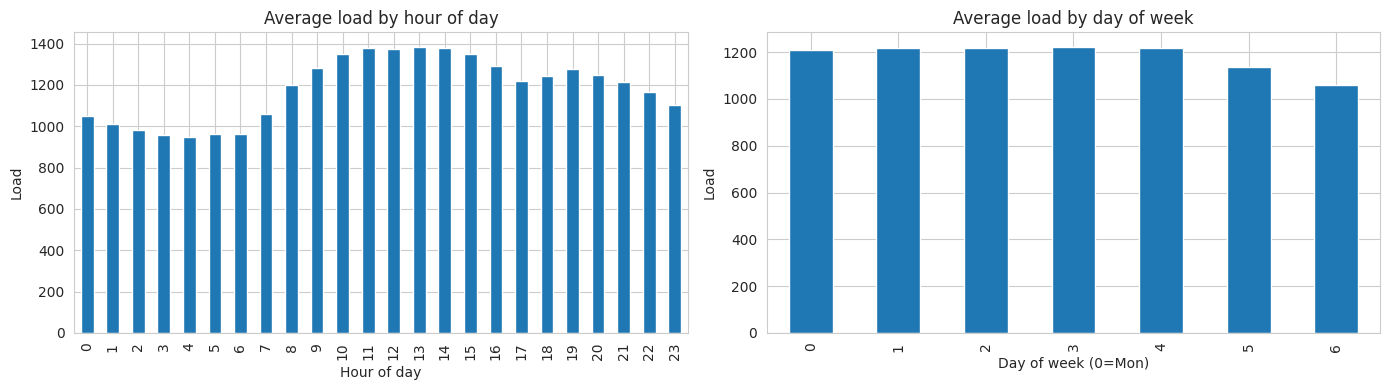

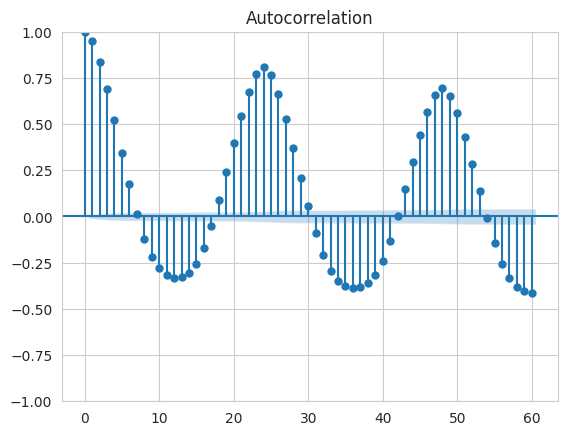

In [5]:
# 3) Average load by hour-of-day and day-of-week
df_feats = data.copy()
df_feats['hour'] = df_feats.index.hour
df_feats['dow'] = df_feats.index.dayofweek
hourly = df_feats.groupby('hour')['load'].mean()
dow = df_feats.groupby('dow')['load'].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
hourly.plot(kind='bar', ax=ax1, title='Average load by hour of day')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Load')
dow.plot(kind='bar', ax=ax2, title='Average load by day of week')
ax2.set_xlabel('Day of week (0=Mon)')
ax2.set_ylabel('Load')
plt.tight_layout()
plot_acf(data['load'].dropna(), lags=60)
plt.show()


- TODO: Inspect the previous plots and comment on the patterns you can distinguish

> Let's comment plot by plot the information we can obtain from each of them
- Entire Time Series (load) - The data covers dates from 2015 to 2020. The load stays more or less between 900 and 1500, with a clear drop in 2020, likely due to the pandemic. There is a slight increase on average throughout the 5 and 1/2 years. 
- Zoom: last 30 days - There is a clear daily and weekly pattern pattern
- Zoom: last 3 days - We can more clearly see the daily pattern. The load incrases throughout the morning, reaching its maximum value after 12 pm and then falls in the afternoon, evening and night
- Average load by hour of day - The tendency described in the previous plot's explanation is reinforced by these values
- Average load by day of week - We can see a lower demand on weekends, especially on Sundays
- Autocorrelation - Strong positive lags at 24h and 48h, which confirms our 24h periodicity. There are negative correlation lags around 12h and 36h due to the oscillation in the pattern.

## Section 2 — Turn time series into supervised learning data

We convert the time series into a tabular supervised problem: predict 1-step-ahead load from lag features, rolling statistics and calendar features.
Fill TODOs in the helper function below.

In [ ]:
def make_supervised(df, target_col='load', horizon=1, lags=None):
    """Create supervised features for a 1-step-ahead forecast."""
    if lags is None:
        lags = [1, 24, 48, 168]  # t-1, t-24 (daily), t-48, t-168 (weekly)
    X = pd.DataFrame(index=df.index)
    # Lag features
    for lag in lags:
        X[f'lag_{lag}'] = df[target_col].shift(lag)
    # Rolling features: 24-hour and 7-day rolling mean/std
    X['rmean_24'] = df[target_col].rolling(window=24, min_periods=1).mean().shift(1)
    X['rstd_24'] = df[target_col].rolling(window=24, min_periods=1).std().shift(1)
    X['rmean_168'] = df[target_col].rolling(window=168, min_periods=1).mean().shift(1)
    # Calendar features
    X['hour'] = df.index.hour
    X['dow'] = df.index.dayofweek
    X['is_weekend'] = (X['dow'] >= 5).astype(int)
    X['month'] = df.index.month
    # Target (1-step ahead by default)
    y = df[target_col].shift(-horizon)
    # Align and drop NaNs caused by shifts
    X = X.loc[~y.isna()]
    y = y.loc[X.index]
    return X, y
# Build supervised data
X, y = make_supervised(data, target_col='load', horizon=1)
print('X shape:', X.shape, 'y shape:', y.shape)
# show a few rows
X.head()

X shape: (48047, 11) y shape: (48047,)


,lag_1,lag_24,lag_48,lag_168,rmean_24,rstd_24,rmean_168,hour,dow,is_weekend,month
datetime,,,,,,,,,,,
2015-01-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,1,1
2015-01-03 02:00:00,970.3450,NaN,NaN,NaN,970.345000,NaN,970.345000,2,5,1,1
2015-01-03 03:00:00,912.1755,NaN,NaN,NaN,941.260250,41.132048,941.260250,3,5,1,1
2015-01-03 04:00:00,900.2688,NaN,NaN,NaN,927.596433,37.496964,927.596433,4,5,1,1
2015-01-03 05:00:00,889.9538,NaN,NaN,NaN,918.185775,35.938700,918.185775,5,5,1,1


## Section 3 — Time-based train / calibration / test split

Random splits leak future information in time series. We'll split chronologically: TRAIN (first 60%), CALIBRATION (next 20%), TEST (last 20%). The calibration set will be used for conformal prediction intervals.


In [7]:
# Chronological split
n = len(X)
i_train = int(n * 0.6)
i_cal = int(n * 0.8)
X_train = X.iloc[:i_train]
y_train = y.iloc[:i_train]
X_cal = X.iloc[i_train:i_cal]
y_cal = y.iloc[i_train:i_cal]
X_test = X.iloc[i_cal:]
y_test = y.iloc[i_cal:]
print('TRAIN range:', X_train.index.min(), 'to', X_train.index.max(), 'size', len(X_train))
print('CAL range:', X_cal.index.min(), 'to', X_cal.index.max(), 'size', len(X_cal))
print('TEST range:', X_test.index.min(), 'to', X_test.index.max(), 'size', len(X_test))

TRAIN range: 2015-01-03 01:00:00 to 2018-04-18 04:00:00 size 28828
CAL range: 2018-04-18 05:00:00 to 2019-05-23 13:00:00 size 9609
TEST range: 2019-05-23 14:00:00 to 2020-06-26 23:00:00 size 9610


## Section 4 — Baseline model and ML model

We compare a naive baseline (previous value) to a trained tree-based regressor. Evaluate using MAE and RMSE.


Naive baseline MAE: 78.688, RMSE: 100.701
RandomForest MAE: 35.885, RMSE: 54.490


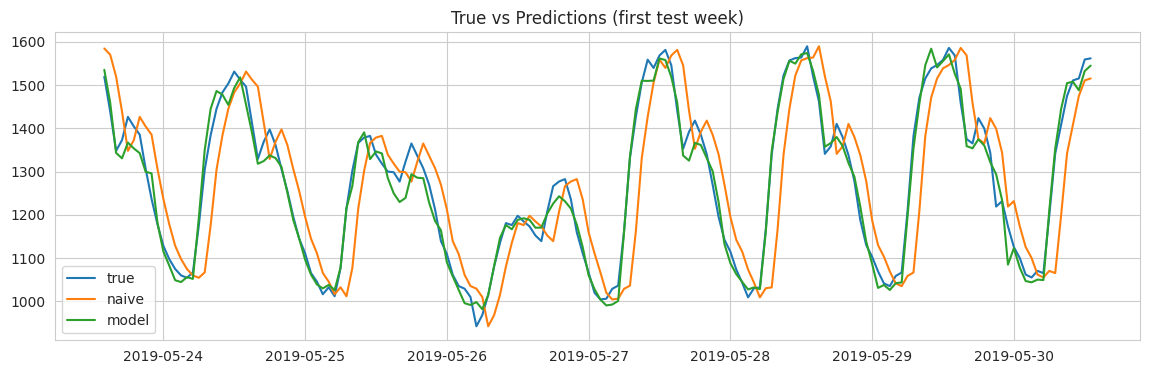

In [8]:
# Naive baseline: predict using lag_1 (t-1). Align carefully.
y_test_index = y_test.index
# Baseline predictions: because target is t, naive is previous observed load at t-1 which is lag_1 feature
yhat_naive = X_test['lag_1']
# Fit a RandomForest as example ML model (students can replace with XGBoost/LGBM)
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
# TODO: fit the model on (X_train, y_train)
model.fit(X_train, y_train)
# Predict on test
yhat = pd.Series(model.predict(X_test), index=X_test.index)
# Evaluation
def evaluate(y_true, y_pred, label='model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print(f'{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}')

evaluate(y_test, yhat_naive, label='Naive baseline')
evaluate(y_test, yhat, label='RandomForest')
# Plot a selected TEST week: choose first week of test set
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    idx = (y_test.index >= plot_start) & (y_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[idx].index, y_test.loc[idx].values, label='true')
    plt.plot(yhat_naive.loc[idx].index, yhat_naive.loc[idx].values, label='naive')
    plt.plot(yhat.loc[idx].index, yhat.loc[idx].values, label='model')
    plt.legend()
    plt.title('True vs Predictions (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot test week:', e)

## Section 5 — Global and local XAI with SHAP

We use SHAP to explain feature importance globally and locally. For tree models, TreeExplainer is efficient. For other models, KernelExplainer may be used but is slower.


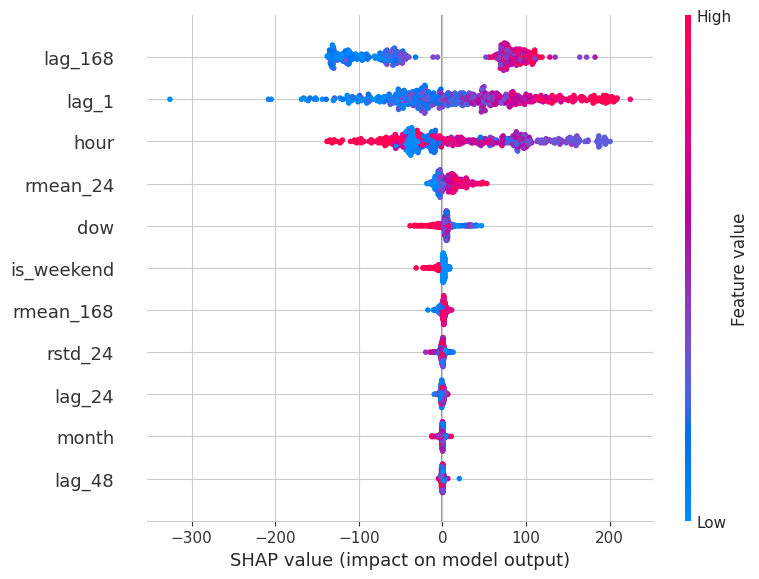

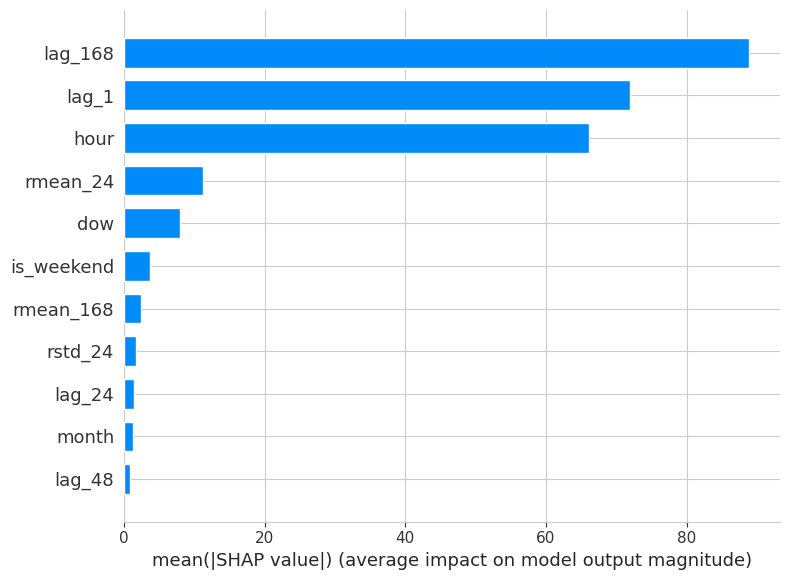

Index with highest load in test: 2020-01-17 13:00:00
Could not produce local SHAP waterfall: The waterfall plot requires an `Explanation` object as the `shap_values` argument.


In [ ]:
# Select a subset of X_test for SHAP analysis (to keep compute small)
X_shap = X_test.sample(n=min(500, len(X_test)), random_state=RANDOM_SEED)
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_shap, show=True)
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=True)
# Local explanation for a single interesting point (e.g., highest true load in test)
idx_max = y_test.idxmax()
print('Index with highest load in test:', idx_max)
x_local = X_test.loc[[idx_max]]
try:
    sv_local = explainer.shap_values(x_local)
    shap.plots.waterfall(sv_local[0] if isinstance(sv_local, list) else sv_local, max_display=12)
except Exception as e:
    print('Could not produce local SHAP waterfall:', e)

- TODO: Interpret SHAP results, are there any innecessary inputs? Try to simplify the model and check performance variations. Does SHAP results match domain intuition?
> Answer:
- **Are there any innecessary inputs? -** Yes, the last inputs are shown to have little influence on the prediction according to SHAP. Especially *lag_48*, *month*, *lag_24*, *rstd_24*, *mean_168* and *is_weekend*.
- **Does SHAP results match domain intuition? -** In most cases, it does. For example, the fact that lag_168 and hour are the most important lags is very straightforward. We live in a very routine-based world, and therefore, from one week to another, our electricity use should be fairly similar at the same time. On the other hand, the previous hour is clearly very indicative of our load the following hour. However, I would have guessed lag_24 had more impact on the prediction, but clearly, I suspect due to the difference between weekdays and weekends, it is not that good an input

In [23]:
# Select top k features
k = 5
top_features = np.argsort(np.abs(shap_values).mean(0))[-k:]
top_feature_names = X_shap.columns[top_features][::-1]
print('Top features by mean absolute SHAP value:', top_feature_names.tolist())

# Select top k features in the datasets
X_test_topk = X_test[top_feature_names]
X_cal_topk = X_cal[top_feature_names]
X_train_topk = X_train[top_feature_names]

# Retrain the model on top k features
model_topk = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)
model_topk.fit(X_train_topk, y_train)

# Predict on test
yhat_topk = pd.Series(model_topk.predict(X_test_topk), index=X_test_topk.index)

# Evaluate
evaluate(y_test, yhat_naive, label='Naive baseline')
evaluate(y_test, yhat, label='RF (all features)')
evaluate(y_test, yhat_topk, label=f'RF (top {k} features)')

Top features by mean absolute SHAP value: ['lag_168', 'lag_1', 'hour', 'rmean_24', 'dow']
Naive baseline MAE: 78.688, RMSE: 100.701
RF (all features) MAE: 35.885, RMSE: 54.490
RF (top 5 features) MAE: 35.638, RMSE: 53.676


**Try to simplify the model and check performmance variations -** As we can see, the performance has remained the same, or even slightly improved (mostly unnoticeable) even though we have trained the model on only 5 out of the 11 total features. This indicates the other features were, not only unnecessary (therefore wasting computational resources), but also might even incur some noise in the prediction (almost none). 

## Section 6 — Bootstrap ensemble for predictive variability

Train B bootstrap models (resampling training data with replacement) to approximate variability due to training data sampling. Use their distribution to produce prediction intervals.


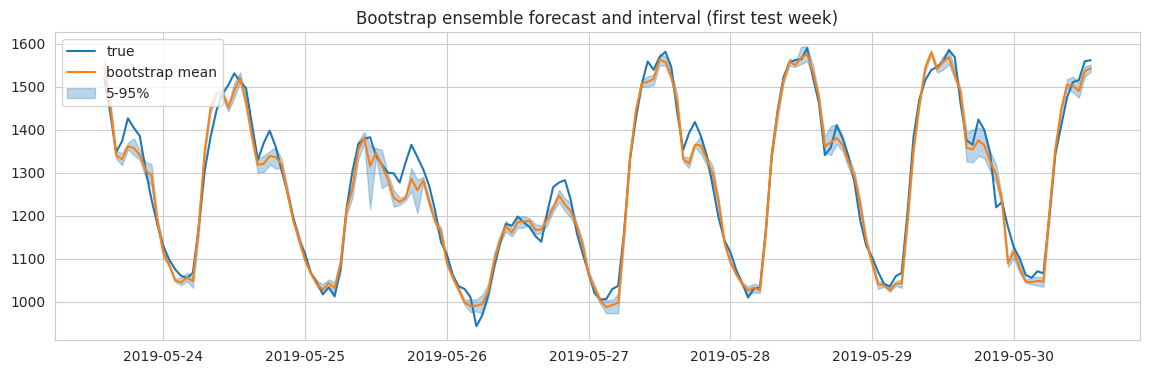

In [24]:
from copy import deepcopy
def bootstrap_models(X_train, y_train, base_model, B=10):
    models = []
    n = len(X_train)
    for b in range(B):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        Xb = X_train.iloc[idx]
        yb = y_train.iloc[idx]
        m = deepcopy(base_model)
        m.fit(Xb, yb)
        models.append(m)
    return models
# Train B bootstrap models (may take time)
B = 10
base = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# TODO: If running time is a concern reduce B or model complexity
models_b = bootstrap_models(X_train, y_train, base, B=B)
# Compute bootstrap predictions for X_test (may be memory heavy; sample a week for plotting)
def bootstrap_predict(models, X):
    preds = np.vstack([m.predict(X) for m in models])  # shape (B, n)
    return preds
preds_b = bootstrap_predict(models_b, X_test)
# Mean and 5th-95th percentile interval
y_mean = preds_b.mean(axis=0)
y_p05 = np.percentile(preds_b, 5, axis=0)
y_p95 = np.percentile(preds_b, 95, axis=0)
# Plot a test week with bootstrap interval
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    mask = (X_test.index >= plot_start) & (X_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[mask].index, y_test.loc[mask].values, label='true')
    plt.plot(X_test.loc[mask].index, y_mean[mask], label='bootstrap mean')
    plt.fill_between(X_test.loc[mask].index, y_p05[mask], y_p95[mask], color='C0', alpha=0.3, label='5-95%')
    plt.legend()
    plt.title('Bootstrap ensemble forecast and interval (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot bootstrap week:', e)

## Section 7 — Conformal prediction intervals (inductive residual-based)

Inductive conformal uses residuals on a held-out calibration set to form a distribution of absolute errors; the quantile gives a symmetric interval around point predictions with finite-sample marginal coverage guarantees (under exchangeability).

Conformal q (alpha=0.1): 45.749855000000025
Coverage on TEST (alpha=0.1): 0.747, avg width: 91.500
   alpha          q  coverage   avg_width
0   0.05  61.489332  0.842664  122.978664
1   0.10  45.749855  0.747242   91.499710
2   0.20  32.138579  0.619667   64.277158


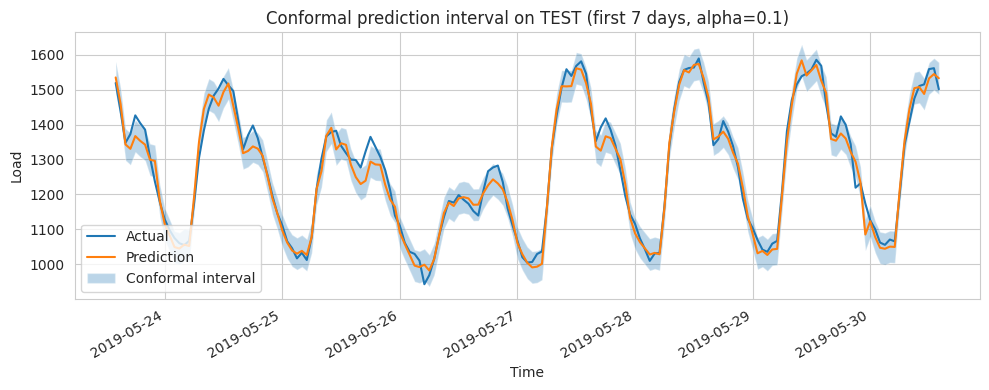

In [25]:
# --- Conformal quantile from calibration residuals ---

# Train a fresh model on TRAIN if desired. We'll reuse `model` already trained, but you can retrain here.
# model.fit(X_train, y_train)

# Predict on calibration set and compute residuals
yhat_cal = pd.Series(model.predict(X_cal), index=X_cal.index)
residuals = (y_cal - yhat_cal).abs()

def conformal_q(residuals, alpha=0.1):
    """
    Compute conformal quantile with finite-sample correction:
    quantile at ceil((n+1)*(1-alpha))/n.
    """
    n = len(residuals)
    k = int(np.ceil((n + 1) * (1 - alpha))) - 1
    q = np.sort(residuals)[k]
    return q

alpha = 0.1
q_alpha = conformal_q(residuals.values, alpha=alpha)
print(f'Conformal q (alpha={alpha}):', q_alpha)

# --- Build intervals on TEST ---

yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha

# Evaluate empirical coverage and average width
inside = ((y_test >= lower) & (y_test <= upper)).mean()
avg_width = (upper - lower).mean()
print(f'Coverage on TEST (alpha={alpha}): {inside:.3f}, avg width: {avg_width:.3f}')

# Optionally loop over several alphas
alphas = [0.05, 0.1, 0.2]
rows = []
for a in alphas:
    q = conformal_q(residuals.values, alpha=a)
    yhat_test_a = pd.Series(model.predict(X_test), index=X_test.index)
    l = yhat_test_a - q
    u = yhat_test_a + q
    cov = ((y_test >= l) & (y_test <= u)).mean()
    rows.append({'alpha': a, 'q': q, 'coverage': cov, 'avg_width': (u - l).mean()})

conformal_summary = pd.DataFrame(rows)
print(conformal_summary)

# --- Plot conformal predictions along the time series (first 7 days of TEST) ---

import matplotlib.pyplot as plt

# Define plot window: first 7 days of the test period
plot_start = X_test.index[0]
plot_end = plot_start + pd.Timedelta(days=7)

mask = (y_test.index >= plot_start) & (y_test.index <= plot_end)

y_test_plot = y_test[mask]
yhat_plot = yhat_test[mask]
lower_plot = lower[mask]
upper_plot = upper[mask]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y_test_plot.index, y_test_plot, label='Actual')
ax.plot(yhat_plot.index, yhat_plot, label='Prediction')
ax.fill_between(yhat_plot.index, lower_plot, upper_plot, alpha=0.3, label='Conformal interval')

ax.set_title(f'Conformal prediction interval on TEST (first 7 days, alpha={alpha})')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


- TODO: Comment on the results, which you find more useful: bootstrap or conformal? Which would you use in case I ask you about uncertainty in forecasting models?
> Answer:

For $\alpha=0.1$ we should get $\approx90\%$ coverage, but we are getting $\approx75\%$ coverage. This means our intervals are too narrow.

The usefullness of each technique depends on what you want to do. 
- Bootstrap tells you how sensitive the model is to the training sample
- Conformal gives you conformal (uncertainty) intervals.

Personally, I find Conformal more useful/informative.

For uncertainty in forecasting models, I would definitely use conformal prediction intervals (as it is the technique's specific goal)

## Section 9 — Using intervals for anomaly flagging

Flag times where true load lies outside conformal intervals — potentially anomalous events requiring operator attention.


Number of anomalies in TEST: 2429


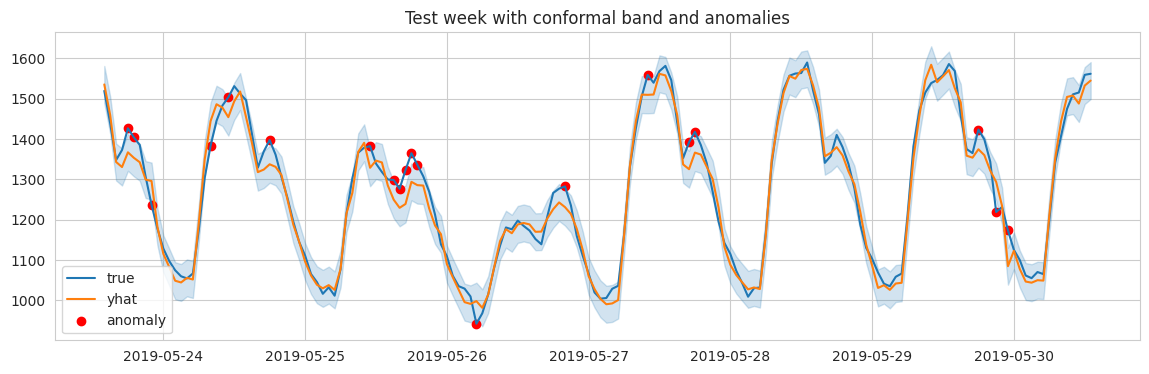

,y_true,yhat,lower,upper,anomaly
datetime,,,,,
2019-05-23 18:00:00,1426.328300,1366.956192,1321.206337,1412.706047,True
2019-05-23 19:00:00,1404.167525,1353.413410,1307.663555,1399.163265,True
2019-05-23 22:00:00,1236.931400,1295.806039,1250.056184,1341.555894,True
2019-05-24 08:00:00,1383.298800,1444.640992,1398.891137,1490.390847,True
2019-05-24 11:00:00,1503.377200,1454.076919,1408.327064,1499.826774,True
2019-05-24 18:00:00,1397.329200,1337.344336,1291.594481,1383.094191,True
2019-05-25 11:00:00,1382.318000,1328.694119,1282.944264,1374.443974,True
2019-05-25 15:00:00,1298.430500,1249.570631,1203.820776,1295.320486,True
2019-05-25 16:00:00,1276.796600,1229.535050,1183.785195,1275.284905,True


In [26]:
# Using alpha chosen earlier
yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha
anomaly = ~( (y_test >= lower) & (y_test <= upper) )
anomalies = pd.DataFrame({'y_true': y_test, 'yhat': yhat_test, 'lower': lower, 'upper': upper, 'anomaly': anomaly})
print('Number of anomalies in TEST:', anomalies['anomaly'].sum())
# Plot a test week with anomalies marked
try:
    mask = (X_test.index >= X_test.index[0]) & (X_test.index < X_test.index[0] + pd.Timedelta(days=7))
    plt.figure(figsize=(14, 4))
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'y_true'], label='true')
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'yhat'], label='yhat')
    plt.fill_between(anomalies.loc[mask].index, anomalies.loc[mask, 'lower'], anomalies.loc[mask, 'upper'], color='C0', alpha=0.2)
    # mark anomalies
    an_idx = anomalies.loc[mask & anomalies['anomaly']].index
    plt.scatter(an_idx, anomalies.loc[an_idx, 'y_true'], color='red', label='anomaly')
    plt.legend()
    plt.title('Test week with conformal band and anomalies')
    plt.show()
except Exception as e:
    print('Could not plot anomalies:', e)
# Print a small table of anomalies (timestamp, y_true, yhat, lower, upper)
anomalies[anomalies['anomaly']].head(20)

- TODO: Are the anomalies true grid events or model errors? Justify your answer
> Answer:
We detected 2429 anomalies. A real electricity grid does not experience thousands of abnormal events per year. True anomalies include system failures and major outages, among others, which are rare events. Most flagged points occur during normal daily peak periods—when the load changes rapidly and the model tends to under (or over) predict, rather than at random or abnormal times. Because the conformal interval was calibrated on a period with smaller residuals, it underestimates the actual variability in the test period, causing many normal points to fall outside the band. Therefore, the red markers represent model prediction errors rather than real anomalies in the system.

## Section 10 — Visualizing

- How would you present these results to non-technical stakeholders at a grid operator? Include visuals and short bullet recommendations. Add as many code and markdown cells as you find necessary.

## Executive Summary

- We built a short-term load forecasting model that predicts electricity demand one hour ahead.
- The model also produces an uncertainty band, which shows how confident the system is about each prediction.
- When the actual load falls outside this band, the system flags a potential anomaly.
- These tools help operators monitor demand stability and identify unusual behaviour.


### 1. Forecast vs Actual Load
![Forecast vs Actual](../images/s4_true_vs_preds.png)

Interpretation:
- The green curve (RandomForest model) follows the daily demand cycles closely and is substantially more accurate than a simple baseline. The model reliably captures normal daily behaviour.


### 2. Feature Importance (Why the Model Predicts What It Predicts)
![Feature Ranking](../images/s5_feature_ranking.png)

Interpretation:
The most influential factors are:

- Load at the same hour last week (lag_168)
- Load one hour ago (lag_1)
- Hour of the day
- Yesterday’s average load
- Day of the week

These match well-known demand patterns and make the model’s behaviour intuitive.


### 3. Bootstrap Uncertainty (Model Stability)
![Bootstrap](../images/s6_boostrap.png)

Interpretation: The shaded region shows variability across 10 bootstrapped versions of the model.
Since the band is narrow, this tells operators:

- The model is stable
- Predictions do not change much when data varies slightly
- Most uncertainty comes from natural load variability, not model instability


### 4. Conformal Prediction Intervals and Anomaly Detection
![Conformal Prediction & Anomalies](../images/s9_anomalies.png)

Conformal prediction intervals give a clear view of how confident the model is about each forecast. The shaded band represents the range where we expect the load to fall, based on typical past prediction errors. When the actual load stays inside the band, behaviour is considered normal. When it falls outside, the system flags a potential anomaly.

Interpretation: Most anomalies occur during periods of rapid load changes (morning and evening peaks), where the model tends to under- or over-predict. These are model limitations, not true grid faults. Operators should treat anomalies as early warnings, not automatic alarms, and investigate only large, persistent, or out-of-pattern deviations.



### Recommendations for Grid Operators
Forecasting
- Model captures typical demand cycles reliably.
- Expect higher uncertainty during rapid load ramps.

Uncertainty Interpretation
- Bootstrap intervals show the model is stable.
- Conformal intervals help quantify expected forecast error.

Anomaly Use
- Use anomalies as early warnings, not definitive signs of faults.
- Prioritize investigation of large or persistent deviations.

Model Improvement Opportunities
- Add weather and temperature data to improve peak prediction.
- Use hour-specific or adaptive conformal intervals to reduce false positives.
- Integrate forecasts + uncertainty bands into a real-time dashboard.